In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import shap
from ChestWorld import ChestWorld
from dqn_agent_new import DqnAgentNew

pygame 2.6.0 (SDL 2.28.4, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# ChestWorld
render_mode=None
size=6
agentSpawn = None
q_values=None
maxSteps=200
stepLoss=-1/maxSteps # min reward should be -1
wallCoordinates=None
randomWalls=0
chestCoordinates=None
keyCoordinates=None
randomchests=5
randomkeys=3
chestReward=1/min(randomchests, randomkeys) # max reward should be 1

# Agent
batch_size=64
lr=0.001
gamma=0.95
epsilon_start=1
epsilon_min=0.05
epsilon_decay=200_000 # 50_000 at 3000 episodes
tau=0.0005 # Was 0.005
replayBuffer=100_000

env = ChestWorld(render_mode=None, size=size, agentSpawn=agentSpawn, stepLoss=stepLoss, maxSteps=maxSteps, wallCoordinates=wallCoordinates, randomWalls=randomWalls, chestCoordinates=chestCoordinates, keyCoordinates=keyCoordinates, chestReward=chestReward, randomchests=randomchests, randomkeys=randomkeys)
observation, _ = env.reset()
agent = DqnAgentNew(env.action_space, observation,
    batch_size=batch_size,
    lr=lr,
    gamma=gamma,
    epsilon_start=epsilon_start,
    epsilon_min=epsilon_min,
    epsilon_decay=epsilon_decay,
    tau=tau,
    replayBuffer=replayBuffer,
    wandb=False)

Action space: 4
Observation space: 6
Observation space[0]: 6
Action space: 4
Observation space: 6
Observation space[0]: 6


In [3]:
agent.replayBuffer=20_000
agent.load_model_weights(f"C:/Projects/public/XAI_NTNU/modelsToEval/CW_5chests_3keys_6x6_10000000steps.pth")
env.render_mode="human"
env.saveImages = True
agent.inference(env=env, max_steps=100, epsilon=epsilon_min, renderQvalues=True)
env.render_mode=None
env.saveImages = False
agent.inference(env=env, max_steps=20_000, epsilon=epsilon_min, renderQvalues=False)

action_direction = {0: "Right",1: "Down",2: "Left", 3: "Up"}
#action_direction = {0: "🠪", 1: "🠫", 2: "🠨", 3: "🠩"}

replayBuffer = agent.replay_buffer
replayBufferStates = [replayBuffer[i][0] for i in range(len(replayBuffer))]
replayBufferStates = torch.stack(replayBufferStates)
replayBufferStates = replayBufferStates.squeeze(1)
print(f"replayBufferStates shape: {replayBufferStates.shape}")


Model loaded: C:/Projects/public/XAI_NTNU/modelsToEval/CW_5chests_3keys_6x6_10000000steps.pth
Saved frame_0000.png
Saved frame_0001.png
1%, time elapsed: 0 minutes and 2.13 seconds, it may finish around: 2024-12-03 15:14:53
Saved frame_0002.png
Saved frame_0003.png
Saved frame_0004.png
Saved frame_0005.png
Saved frame_0006.png
Saved frame_0007.png
Saved frame_0008.png
Saved frame_0009.png
Saved frame_0010.png
10%, time elapsed: 0 minutes and 11.14 seconds, it may finish around: 2024-12-03 15:13:11
Saved frame_0011.png
Saved frame_0012.png
Saved frame_0013.png
Saved frame_0014.png
Saved frame_0015.png
Saved frame_0016.png
Saved frame_0017.png
Saved frame_0018.png
Saved frame_0019.png
Saved frame_0020.png
Saved frame_0021.png
Saved frame_0022.png
Saved frame_0023.png
Saved frame_0024.png
Saved frame_0025.png
Saved frame_0026.png
Saved frame_0027.png
Saved frame_0028.png
Saved frame_0029.png
Saved frame_0030.png
Saved frame_0031.png
Saved frame_0032.png
Saved frame_0033.png
Saved frame_00

In [4]:
model = agent.policy_net
print(f"replayBufferStates shape: {replayBufferStates.shape}")
unique_states = torch.unique(replayBufferStates[100:], dim=0)
print(f"unique_states shape: {unique_states.shape}")
background = unique_states[np.random.choice(unique_states.shape[0], 10_000, replace=False)]
print(f"background shape: {background.shape}")
statesToExplain = replayBufferStates[:100]
print(f"Background[0]: {background[0]}")
"""

# loop for background
for i in range(len(background)):
    backgroundAsImage = (background[i].numpy() * 255).astype(np.uint8)
    plt.imshow(backgroundAsImage)
    plt.axis('off')
    plt.title(f'Background[{i}] Visualization')
    plt.show()

    #plt.savefig(f'background_{i}.png', bbox_inches='tight')

for i in range(len(statesToExplain)):
    statesToExplainAsImage = (statesToExplain[i].numpy() * 255).astype(np.uint8)
    plt.imshow(statesToExplainAsImage)
    plt.axis('off')
    plt.title(f'State to explain Visualization')
    plt.show()

    #plt.savefig(f'stateToExplain_{i}.png', bbox_inches='tight')
"""

replayBufferStates shape: torch.Size([20116, 6, 6, 3])
unique_states shape: torch.Size([17972, 6, 6, 3])
background shape: torch.Size([10000, 6, 6, 3])
Background[0]: tensor([[[1.0000, 1.0000, 1.0000],
         [1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [0.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.00

"\n\n# loop for background\nfor i in range(len(background)):\n    backgroundAsImage = (background[i].numpy() * 255).astype(np.uint8)\n    plt.imshow(backgroundAsImage)\n    plt.axis('off')\n    plt.title(f'Background[{i}] Visualization')\n    plt.show()\n\n    #plt.savefig(f'background_{i}.png', bbox_inches='tight')\n\nfor i in range(len(statesToExplain)):\n    statesToExplainAsImage = (statesToExplain[i].numpy() * 255).astype(np.uint8)\n    plt.imshow(statesToExplainAsImage)\n    plt.axis('off')\n    plt.title(f'State to explain Visualization')\n    plt.show()\n\n    #plt.savefig(f'stateToExplain_{i}.png', bbox_inches='tight')\n"

In [5]:
e = shap.GradientExplainer(model=model,
                       data=background)

Test states shape: torch.Size([100, 6, 6, 3])
Predictions: [[0.62601525 0.6070475  0.6233984  0.6647817 ]
 [0.60838115 0.61187065 0.60383046 0.6278974 ]
 [0.68616974 0.6315546  0.6170027  0.62932456]
 [0.67491597 0.6496476  0.7392771  0.70328456]
 [0.35960883 0.4123465  0.40175927 0.38347882]
 [0.3727929  0.43792403 0.43398947 0.40019268]
 [0.4135819  0.42251962 0.4717192  0.4200769 ]
 [0.45774603 0.45083237 0.52031255 0.45348608]
 [0.4634592  0.511725   0.4971831  0.47535026]
 [0.19579196 0.18910535 0.16235177 0.16611394]
 [0.22227529 0.22245401 0.17760439 0.184559  ]
 [0.24243897 0.2095255  0.17211021 0.19548544]
 [0.27232945 0.24232116 0.20559588 0.20155925]
 [0.2762228  0.26080638 0.24265629 0.24847104]
 [0.27972126 0.27616012 0.32130477 0.28464425]
 [0.61750215 0.6177484  0.71308315 0.66154325]
 [0.64336413 0.6254888  0.75439477 0.6733573 ]
 [0.6794802  0.7017699  0.7796669  0.77683735]
 [0.42861396 0.40247655 0.4479334  0.49636233]
 [0.52382445 0.5135857  0.4864163  0.49535722]
 

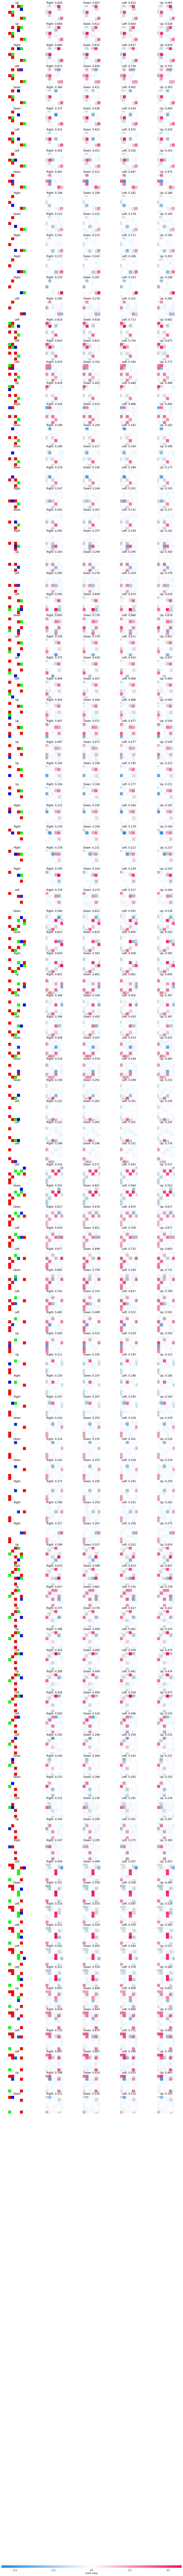

In [6]:
print(f"Test states shape: {statesToExplain.shape}")
with torch.no_grad():
    predictions = model(statesToExplain).detach().numpy()
    argmax = [action_direction[np.argmax(prediction)] for prediction in predictions]
    print(f"Predictions: {predictions}")
    print(f"Argmax: {argmax}")

print(f"Test states type: {type(statesToExplain)}")

shap_values = e.shap_values(statesToExplain) #, check_additivity=False)
"""AssertionError: The SHAP explanations do not sum up to the
model's output! This is either because of a rounding error or
because an operator in your computation graph was not fully
supported. If the sum difference of %f is significant compared
to the scale of your model outputs, please post as a github issue,
with a reproducible example so we can debug it. Used framework:
    pytorch - Max. diff: 0.07974889467004687 - Tolerance: 0.01"""
# check_additivity was set to False for this reason
# this error needs to be fixed since it gives a feulty result

"""The last one was
Max. diff: 0.9542994634248316 - Tolerance: 0.01
Intolerable..."""

shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 1, 3)))
test_numpy = np.transpose(statesToExplain.numpy(), (0, 2, 1, 3))

labels = np.array([[f"{action_direction[i]}: {predictions[j][i]:.3f}" for i in range(len(predictions[j]))] for j in range(len(predictions))])

# plot the feature attributions
shap.image_plot(shap_values=shap_numpy,
                pixel_values=test_numpy,
                labels=labels,
                true_labels=argmax,)
#                labelpad=0,
#                width=18)

In [7]:
print(f"test_states[0]: {statesToExplain[0]}")

test_states[0]: tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 0., 0.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 0., 0.],
         [1., 1., 1.],
         [0., 1., 0.],
         [1., 0., 0.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 0., 0.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[0., 1., 0.],
         [0., 0., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 0., 0.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [0., 1., 0.],
         [1., 1., 1.]]])
